In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage
import imagecodecs
from skimage.filters import sobel
from skimage import morphology
from skimage.util import img_as_ubyte
from skimage.color import rgb2gray
from scipy import ndimage as ndi
from matplotlib import image
from skimage.color import label2rgb


def load_image(path):
    """Load input image"""
    # Read image
    img = image.imread(path)
    # Convert to grayscale
    img = rgb2gray(img)
    # Convert to 2D array with values from 0 to 255
    img = img_as_ubyte(img)
    # Return image as 2D numpy array
    return img

# Create histogram of gray values in image
# Can be used to determine bg and fg values in testing
def make_histogram(image):
    """
    # Create histogram of gray values in image
    # Can be used to determine bg and fg values in testing
    """
    # Actual making of histogram
    hist = np.histogram(image, bins=np.arange(0, 256))
    #print(hist)
    # Graphing the histogram next to the image
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
    ax1.imshow(image, cmap=plt.cm.gray, interpolation='nearest')
    ax1.axis('off')
    ax2.plot(hist[1][:-1], hist[0], lw=2)
    ax2.set_title('histogram of grey values')
    plt.show()
    # Return histogram
    return hist


def watershed_seg(image, sure_fg, sure_bg):
    """Apply watershed algorithm to find bands"""
    # Use Sobel filter on original image to find elevation map
    elevation_map = sobel(image)
    # Define markers for the background and foreground of the image
    markers = np.zeros_like(image)
    markers[image < sure_bg] = 1  # <120
    markers[image > sure_fg] = 2  # >190
    # Apply the watershed algorithm itself, using the elevation map and markers
    segmentation = morphology.watershed(elevation_map, markers)
    # Fill holes and relabel bands, giving each a unique label
    segmentation = ndi.binary_fill_holes(segmentation - 1)
    labeled_bands, _ = ndi.label(segmentation)
    # Overlay labels on original image
    image_label_overlay = label2rgb(labeled_bands, image=image)
    # Plot image
    plt.figure()
    plt.title("Region-based Segmentation")
    plt.imshow(image_label_overlay)
    print(labeled_bands)
    # Return 2D array of same shape as orig. image with unique band labels
    return labeled_bands


# Not actually used, will take a few years to execute
# Note overlapp is deliberately mispelled to enable usage of overlap() elsewhere
def overlapp(label1, label2):
    discarded_label_values = []
    for r in range(0, len(label2)):
        if (label2[r] == label2[0]).all():
            continue
        for i in range(0, len(label2[r])):
            if label2[r][i] > 0:
                if label1[r][i] > 0:
                    discarded_label_values.append(label2[r][i])
                    print(r,i)
    for row in label2:
        for item in row:
            if item in discarded_label_values:
                item = 0
                print(row, item)
    return label2



def expand_areas(original_image, labeled_image, sure_bg):
    """Expand the areas of the found bands to those adjacent pixels which
    would potentially make bands on the next pass. Create a mask from them."""
    # Get properties of the labeled bands (will use to find centroid of bands)
    props = skimage.measure.regionprops(labeled_image)
    # Initialize output image
    output_image = np.zeros_like(original_image)
    # For each band
    for band in props:
        # Define centroid
        centroid = band.centroid
        # Set seed point to closest integer coord pair to centroid
        seed_point = (round(centroid[0]), round(centroid[1]))
        print(seed_point)
        # Initialize flooding image as full of zeros
        image_for_flood = np.zeros_like(original_image)
        # Set every pixel in flooding image that could possibly make a new band next pass to 1
        image_for_flood[original_image > sure_bg - 30] = 1
        # Use floodfill on the flooding image using the found bands
        # This will ideally exclude any areas that neighbour found bands from being considered as bands
        output_image_part = skimage.segmentation.flood(image_for_flood, seed_point, tolerance=None)
        # Add the excluded areas of each iteration to final excluded area
        output_image += output_image_part
        #plt.figure()
        #plt.title("Mask")
        #plt.imshow(output_image_part)
    return output_image


# overlap(watershed_seg(load_image("../samples/image3.tif"), 100, 120))


0


C:\Users\HP Pavilion\anaconda3\envs\internship2021\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\HP Pavilion\anaconda3\envs\internship2021\lib\site-packages\ipykernel_launcher.py:61: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(47, 956)
(70, 1214)
(73, 1213)
(76, 1211)
(158, 832)
(402, 303)
(462, 843)
(469, 763)
(469, 603)
(470, 365)
(470, 445)
(470, 524)
(469, 685)
(471, 287)
(592, 359)
(964, 205)
1


C:\Users\HP Pavilion\anaconda3\envs\internship2021\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\HP Pavilion\anaconda3\envs\internship2021\lib\site-packages\ipykernel_launcher.py:61: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(956, 195)


C:\Users\HP Pavilion\anaconda3\envs\internship2021\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.


(47.0, 956.0)
1
(70.5, 1214.0)
4
(73.0, 1213.0)
1
(75.5, 1211.0)
2
(158.25, 832.0)
4
(402.0, 303.0)
1
(462.4674441205053, 842.8785228377066)
1029
(468.7298850574713, 762.9770114942529)
696
(469.07894736842104, 603.1271929824561)
684
(469.88993710691824, 365.49528301886795)
636
(469.79615952732644, 444.8847858197932)
677
(469.5, 523.9185303514377)
626
(468.6054279749478, 684.5845511482255)
479
(470.86541244573084, 287.3863965267728)
691
(592.0, 359.0)
1
(956.1666666666666, 195.16666666666666)
6
(964.4, 205.2)
5


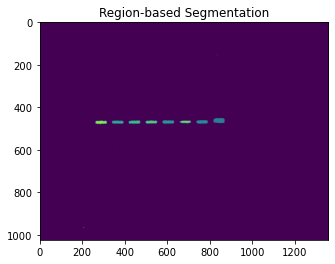

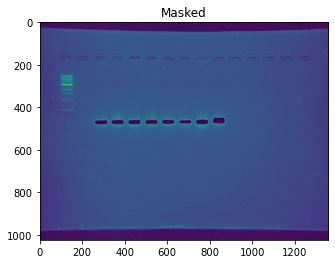

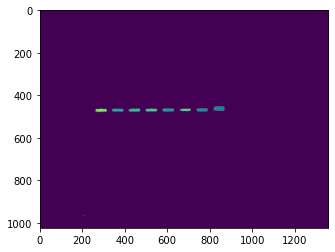

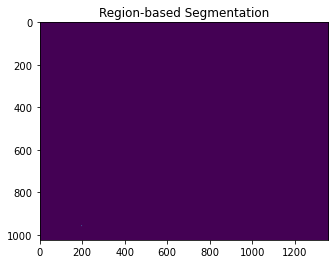

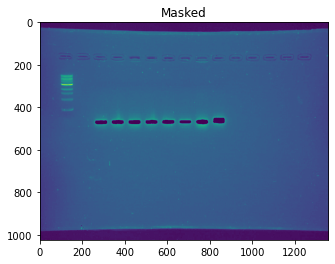

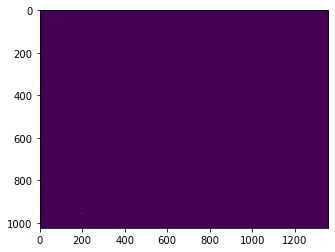

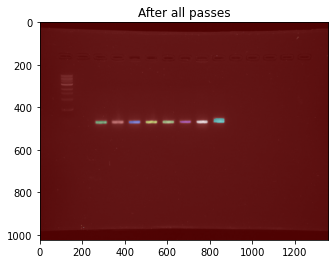

In [10]:
#####
# Amount of times to repeat watershed algorithm
repetitions = 2

# Load image
img = load_image("../UVP02064June72019.jpg")

# Set starting fg and bg values
sure_fg = 120
sure_bg = 100

# Create copy of loaded image to apply mask to
working_img = img.copy()
# Create template for labels
final_labels = np.zeros_like(img, dtype="int32")

# Repeat the watershed algorithm "repetitions" times
for i in range(0, repetitions):
    print(i)
    # Run watershed algorithm
    label_set = watershed_seg(working_img, sure_fg, sure_bg)
    # Add found bands from this iteration to all found bands
    final_labels += label_set
    # Create mask
    mask = expand_areas(working_img, label_set, sure_bg)
    # Apply mask
    working_img[mask > 0] = 0
    plt.figure()
    plt.title("Masked")
    plt.imshow(working_img)
    # Reduce fg and bg values on each pass
    sure_fg -= 20
    sure_bg -= 20
    plt.figure()
    plt.imshow(label_set)    


# Relabel bands to ensure correct labelling
labeled_fbands, _ = ndi.label(final_labels)
# Overlay found bands on original image
final_overlay = label2rgb(labeled_fbands, image=img)

props = skimage.measure.regionprops(labeled_fbands)
for band in props:
    print(band.centroid)
    print(band.area)

# Show final result 
plt.figure()
plt.title("After all passes")
plt.imshow(final_overlay)

image.imsave("2_A_result.jpg", final_overlay)